In [1]:
format(Sys.time(), tz = "Asia/Tokyo", usetz = TRUE)

[1] "2025-08-27 15:46:47 JST"

# Environment

In [2]:
library(msigdbr)
library(dplyr)
library(tibble)
library(purrr)
library(stringr)
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
library(ggplot2)


library(Seurat)
library(patchwork)
library(tidyverse) 

set.seed(1234)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame,

In [3]:
BiocManager::install("org.Mm.eg.db")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.26), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'org.Mm.eg.db'”
Old packages: 'ade4', 'ape', 'aplot', 'AUCell', 'Banksy', 'bedr',
  'BiocFileCache', 'bookdown', 'broom', 'bslib', 'Cairo', 'caret', 'ccTensor',
  'CelliD', 'checkmate', 'cicero', 'ClassDiscovery', 'clock', 'cowplot',
  'crosstalk', 'crul', 'cubature', 'curl', 'data.tree', 'dbscan', 'dendextend',
  'DescTools', 'dials', 'doBy', 'doFuture', 'emmeans', 'FactoMineR',
  'fastDummies', 'fields', 'fitdistrplus', 'flexmix', 'FlexParamCurve', 'FSA',
  'fstcore', 'future', 'future.apply', 'gam', 'gamlss', 'gert', 'GGally',
  'gganimate', 'ggforce', 'ggfortify', 'ggfun', 'ggnewscale', 'ggpubr

In [4]:
install.packages("ontologyIndex")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# GO analysis
reference code: 
https://www.melbournebioinformatics.org.au/tutorials/tutorials/seurat-go/seurat-go/

In [5]:
library(org.Mm.eg.db)

In [6]:
org.Mm.eg.db


Please see: help('select') for usage information



OrgDb object:
| DBSCHEMAVERSION: 2.1
| Db type: OrgDb
| Supporting package: AnnotationDbi
| DBSCHEMA: MOUSE_DB
| ORGANISM: Mus musculus
| SPECIES: Mouse
| EGSOURCEDATE: 2024-Mar12
| EGSOURCENAME: Entrez Gene
| EGSOURCEURL: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA
| CENTRALID: EG
| TAXID: 10090
| GOSOURCENAME: Gene Ontology
| GOSOURCEURL: http://current.geneontology.org/ontology/go-basic.obo
| GOSOURCEDATE: 2024-01-17
| GOEGSOURCEDATE: 2024-Mar12
| GOEGSOURCENAME: Entrez Gene
| GOEGSOURCEURL: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA
| KEGGSOURCENAME: KEGG GENOME
| KEGGSOURCEURL: ftp://ftp.genome.jp/pub/kegg/genomes
| KEGGSOURCEDATE: 2011-Mar15
| GPSOURCENAME: UCSC Genome Bioinformatics (Mus musculus)
| GPSOURCEURL: 
| GPSOURCEDATE: 2024-Feb29
| ENSOURCEDATE: 2023-Nov22
| ENSOURCENAME: Ensembl
| ENSOURCEURL: ftp://ftp.ensembl.org/pub/current_fasta
| UPSOURCENAME: Uniprot
| UPSOURCEURL: http://www.UniProt.org/
| UPSOURCEDATE: Thu Apr 18 21:47:52 2024

# GO Data

In [7]:
library(ontologyIndex)

In [8]:
# Read GO file
go <- get_ontology("../../data/go/go.obo")

In [9]:
descendant_terms <- get_descendants(get_ontology("../../data/go/go.obo"), roots="GO:0002376")

# MDSC data

In [10]:
MDSC <- readRDS("../../results/sc_rna/06_02_myeloid/intermediate/01_clustering/mono.rds")

In [11]:
MDSC

An object of class Seurat 
16245 features across 3695 samples within 1 assay 
Active assay: RNA (16245 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 3 dimensional reductions calculated: pca, umap, tsne

In [12]:
mdsc_markers <- FindAllMarkers(
  MDSC,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



# Filter Gene

In [13]:
gene_list <- Features(MDSC)
gene_name <- data.frame(gene_list)

In [14]:
head(gene_list)

[1] "Mrpl15"        "Lypla1"        "Tcea1"         "Atp6v1h"      
[5] "Rb1cc1"        "4732440D04Rik"

In [15]:
head(gene_name)

,gene_list
,<chr>
1,Mrpl15
2,Lypla1
3,Tcea1
4,Atp6v1h
5,Rb1cc1
6,4732440D04Rik


## Find marker genes for Each Cluster

In [16]:
Cluster0.markers <- mdsc_markers[mdsc_markers$cluster==0 & mdsc_markers$p_val_adj < 0.05, ]
Cluster1.markers <- mdsc_markers[mdsc_markers$cluster==1 & mdsc_markers$p_val_adj < 0.05, ]
Cluster2.markers <- mdsc_markers[mdsc_markers$cluster==2 & mdsc_markers$p_val_adj < 0.05, ]
Cluster3.markers <- mdsc_markers[mdsc_markers$cluster==3 & mdsc_markers$p_val_adj < 0.05, ]

Cluster0_filter.markers <- mdsc_markers[mdsc_markers$cluster==0 & mdsc_markers$p_val_adj < 0.05, ]
Cluster1_filter.markers <- mdsc_markers[mdsc_markers$cluster==1 & mdsc_markers$p_val_adj < 0.05, ]
Cluster2_filter.markers <- mdsc_markers[mdsc_markers$cluster==2 & mdsc_markers$p_val_adj < 0.05, ]
Cluster3_filter.markers <- mdsc_markers[mdsc_markers$cluster==3 & mdsc_markers$p_val_adj < 0.05, ]

# convert gene list
convert_gene0 <- gene_name %>% filter(!(gene_list %in% Cluster0.markers$gene)) 
convert_gene1 <- gene_name %>% filter(!(gene_list %in% Cluster1.markers$gene)) 
convert_gene2 <- gene_name %>% filter(!(gene_list %in% Cluster2.markers$gene)) 
convert_gene3 <- gene_name %>% filter(!(gene_list %in% Cluster3.markers$gene)) 

## Convert gene symbols to Entrez IDs

In [17]:
Cluster0.gene_ids <- bitr(Cluster0.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster1.gene_ids <- bitr(Cluster1.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster2.gene_ids <- bitr(Cluster2.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster3.gene_ids <- bitr(Cluster3.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)

Cluster0_filter.gene_ids <- bitr(Cluster0_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster1_filter.gene_ids <- bitr(Cluster1_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster2_filter.gene_ids <- bitr(Cluster2_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster3_filter.gene_ids <- bitr(Cluster3_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)

Cluster0_convert.gene_ids <- bitr(convert_gene0$gene_list, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster1_convert.gene_ids <- bitr(convert_gene1$gene_list, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster2_convert.gene_ids <- bitr(convert_gene2$gene_list, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster3_convert.gene_ids <- bitr(convert_gene3$gene_list, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster0.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2.43% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster1.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2.55% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster2.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“4.07% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster3.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster0_filter.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2.43% of input gene IDs are fail to map...”
'select()' returned 1:1 ma

In [18]:
out_dir     <- "../../results/sc_rna/06_04_GO/"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)
write.csv(Cluster0.gene_ids, file = file.path(out_dir, "Cluster0_gene_ids.csv"))
write.csv(Cluster1.gene_ids, file = file.path(out_dir, "Cluster1_gene_ids.csv"))
write.csv(Cluster2.gene_ids, file = file.path(out_dir, "Cluster2_gene_ids.csv"))
write.csv(Cluster3.gene_ids, file = file.path(out_dir, "Cluster3_gene_ids.csv"))

# Cluster 0


## 0-1. GO regulation for Cluster 0

In [19]:
Cluster0.ego <- enrichGO(gene = Cluster0.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

In [20]:
Cluster0_ego_df <- as.data.frame(Cluster0.ego)
write.csv(Cluster0_ego_df, file = file.path(out_dir, "Cluster0_ego.csv"))

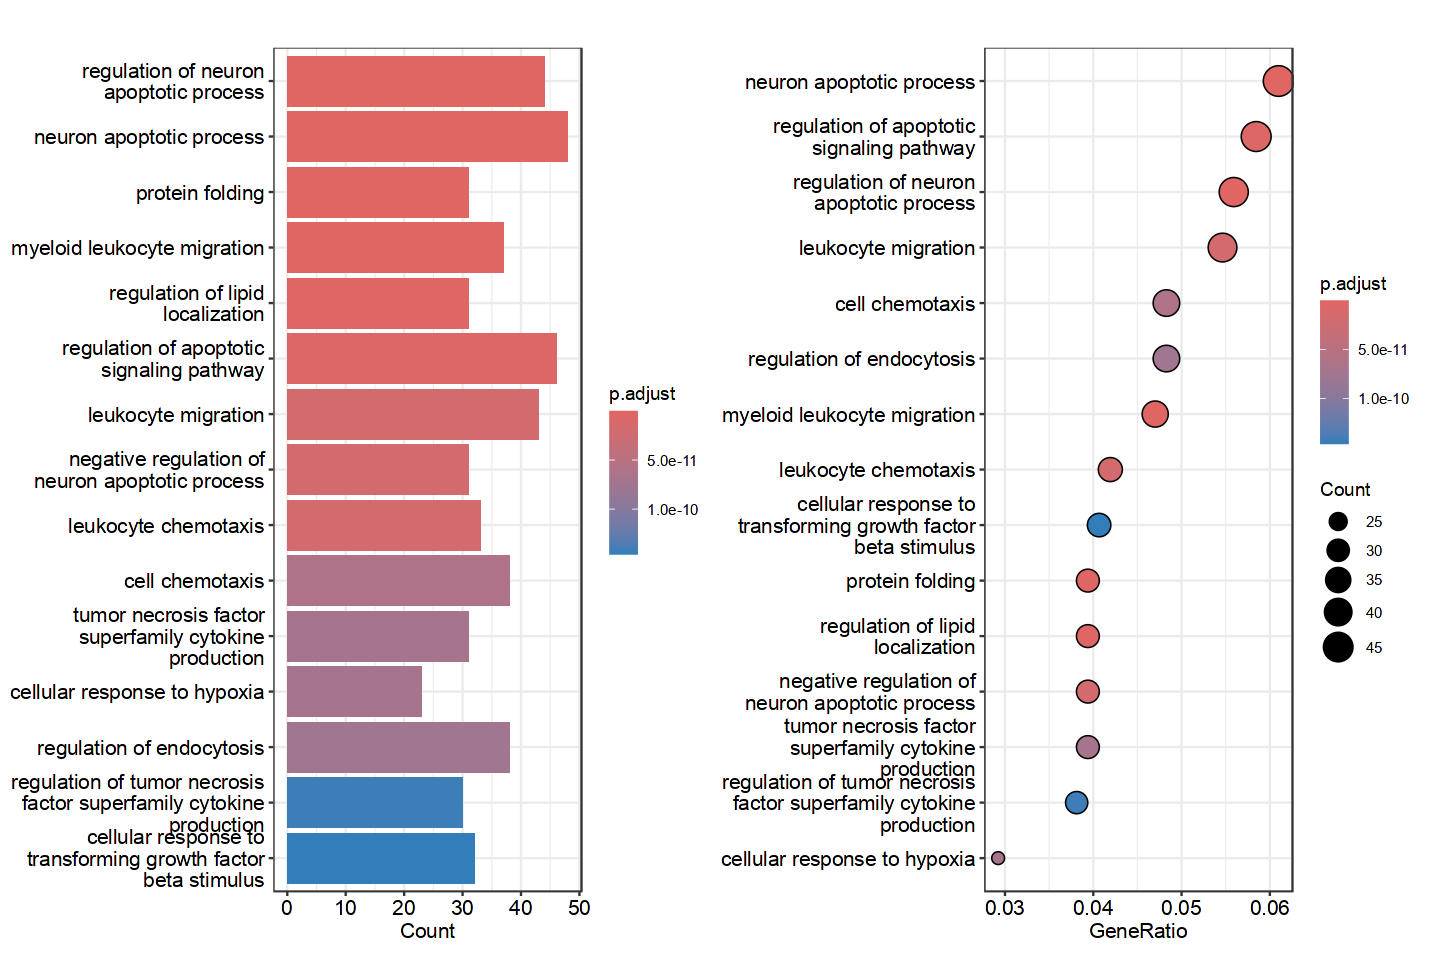

In [21]:
p0<-barplot(Cluster0.ego, showCategory=15)
p1 <- dotplot(Cluster0.ego, showCategory=15)

options(repr.plot.width = 12, repr.plot.height = 8)
p0+p1

In [22]:
Cluster0.ego.simplify <- simplify(Cluster0.ego)

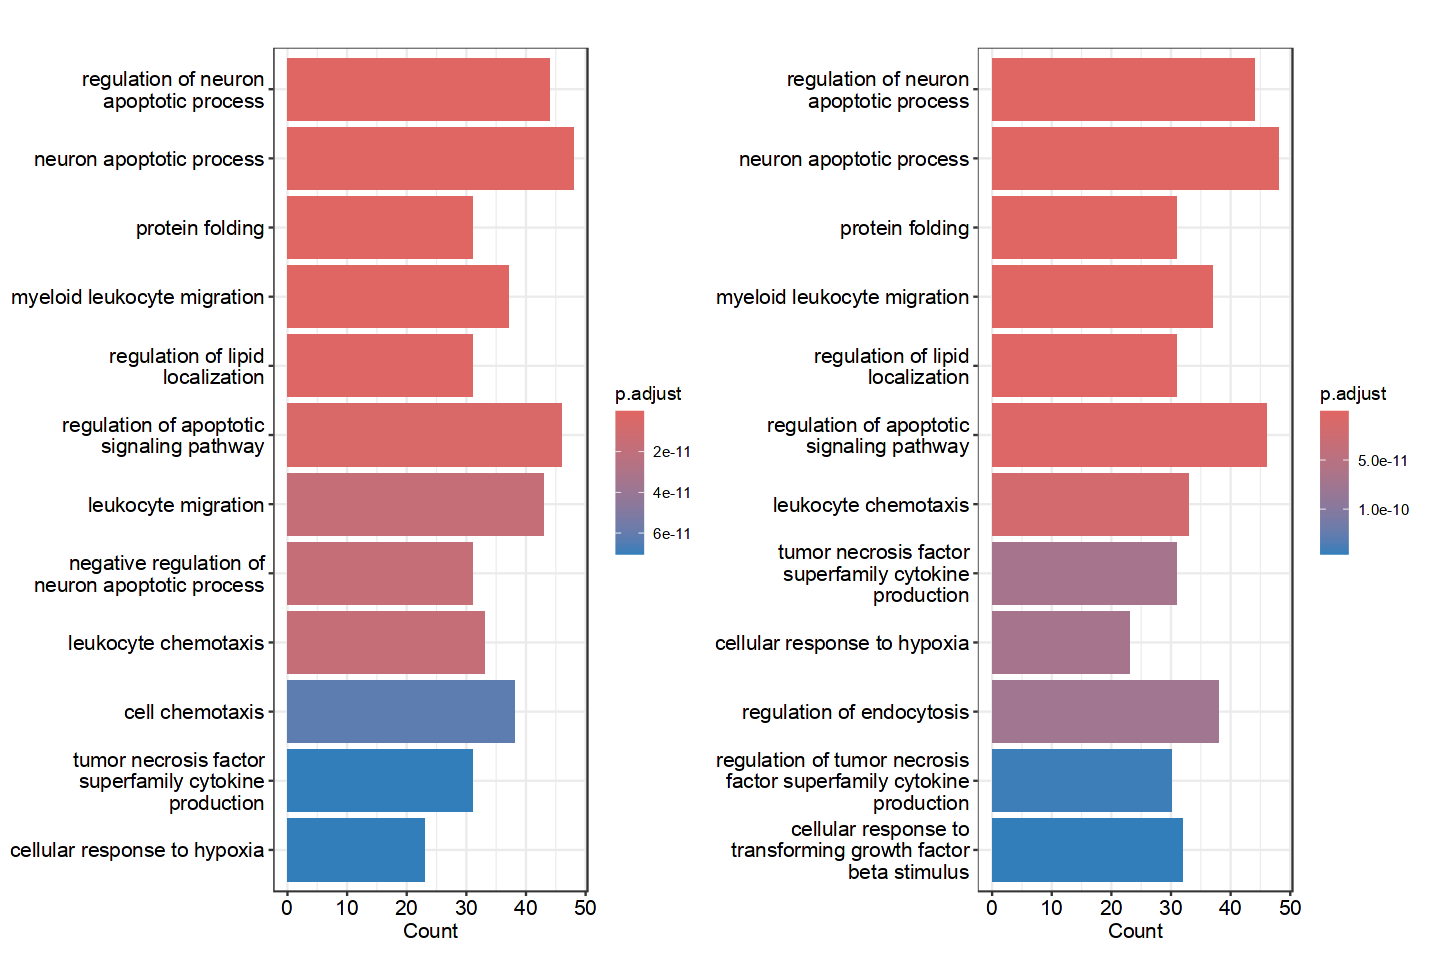

In [23]:
options(repr.plot.width = 6, repr.plot.height = 8)
p0<-barplot(Cluster0.ego, showCategory=12)
p0_s<-barplot(Cluster0.ego.simplify, drop=TRUE, showCategory=12)
options(repr.plot.width = 12, repr.plot.height = 8)
p0+p0_s

## 0-2. Immune related GO analysis

In [24]:
Cluster0_filter.ego <- enrichGO(gene = Cluster0_filter.gene_ids$ENTREZID, 
                        OrgDb = org.Mm.eg.db, 
                        ont = "BP", # biological process
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

In [25]:
Cluster0_filter.ego@result <- Cluster0_filter.ego@result[Cluster0_filter.ego@result$ID %in% descendant_terms,]

In [26]:
Cluster0_filter.ego.simplify <- simplify(Cluster0_filter.ego)

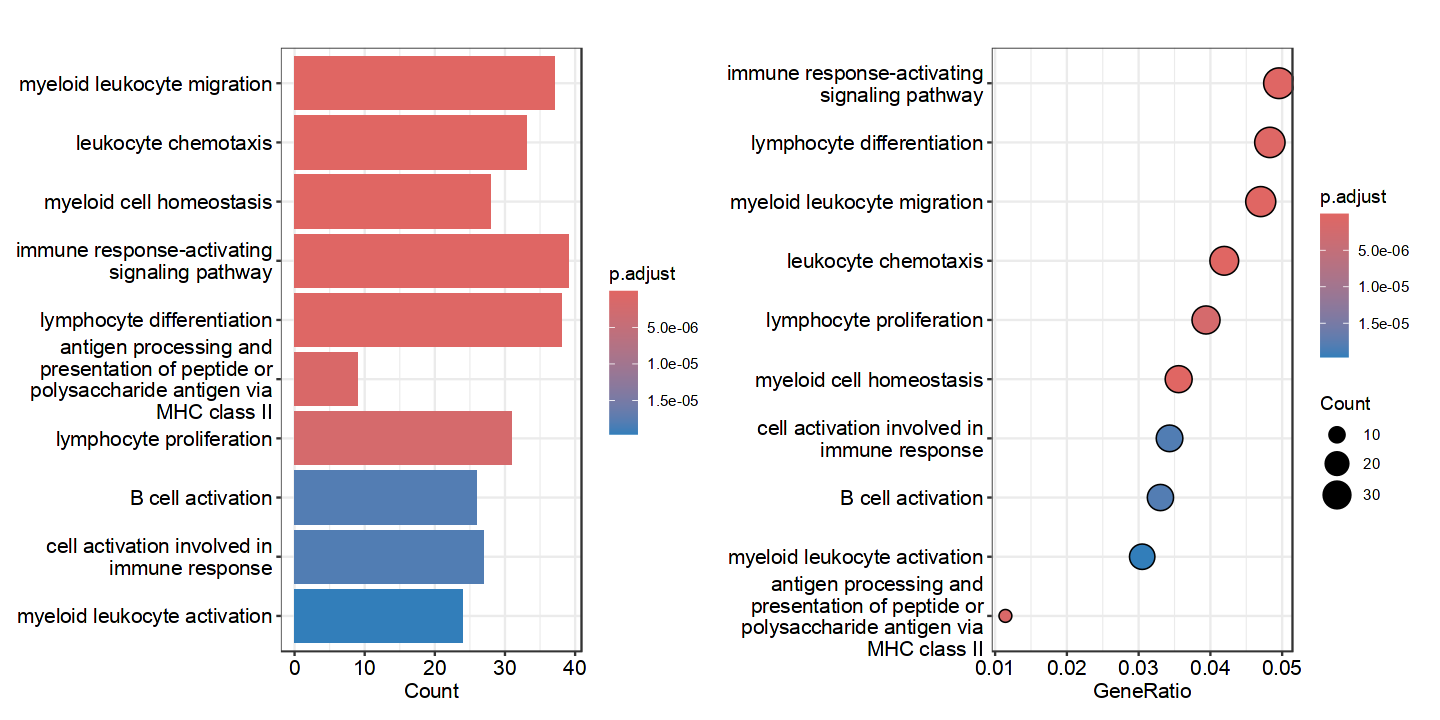

In [27]:
# GO immune related response Analysis for Cluster 0
p0 <- barplot(Cluster0_filter.ego.simplify, showCategory=10)
p1 <- dotplot(Cluster0_filter.ego.simplify, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

## 0-3. Depletion alaysis

In [28]:
Cluster0_convert.ego <- enrichGO(gene = Cluster0_convert.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

In [29]:
Cluster0_convert.ego@result <- Cluster0_convert.ego@result[Cluster0_convert.ego@result$ID %in% descendant_terms,]

In [30]:
Cluster0_convert.ego.simplify <- simplify(Cluster0_convert.ego)

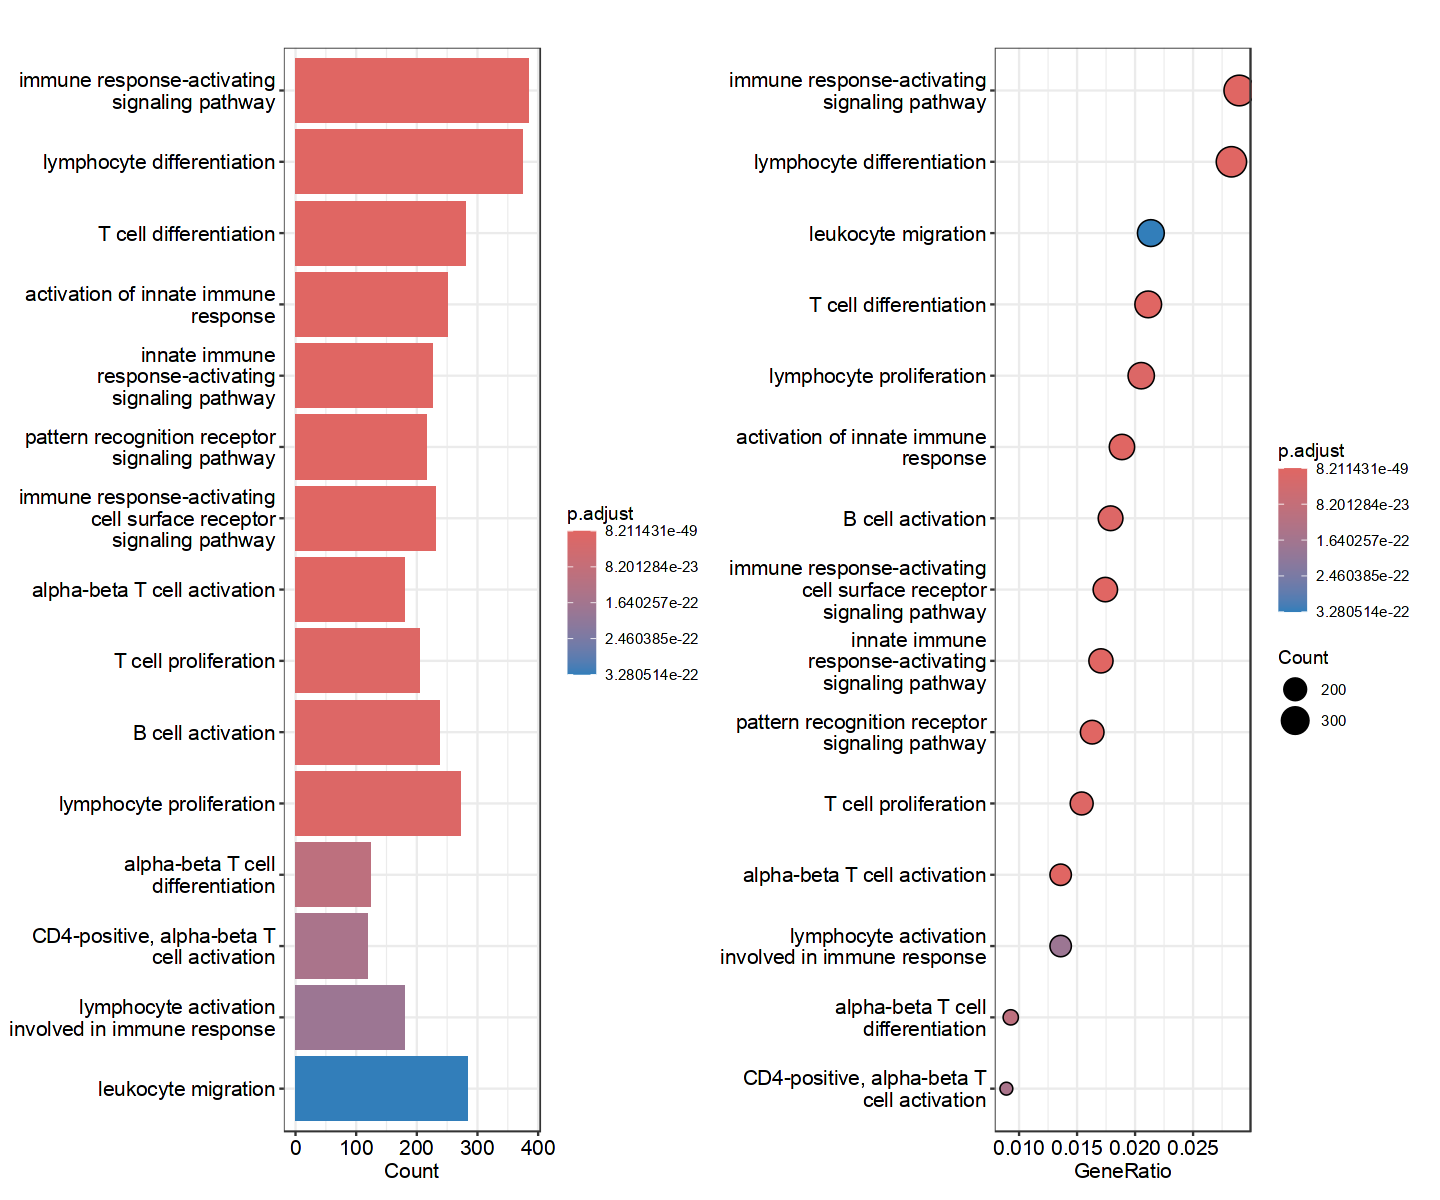

In [31]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0_convert.ego, showCategory=15)
p1<-dotplot(Cluster0_convert.ego, showCategory=15)
options(repr.plot.width = 12, repr.plot.height = 10)
p0+p1

# Cluster 1

## 1-1. GO regulation for Cluster 1

In [32]:
Cluster1.ego <- enrichGO(gene = Cluster1.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

In [33]:
Cluster1_ego_df <- as.data.frame(Cluster1.ego)
write.csv(Cluster1_ego_df, file = file.path(out_dir, "Cluster1_ego.csv"))

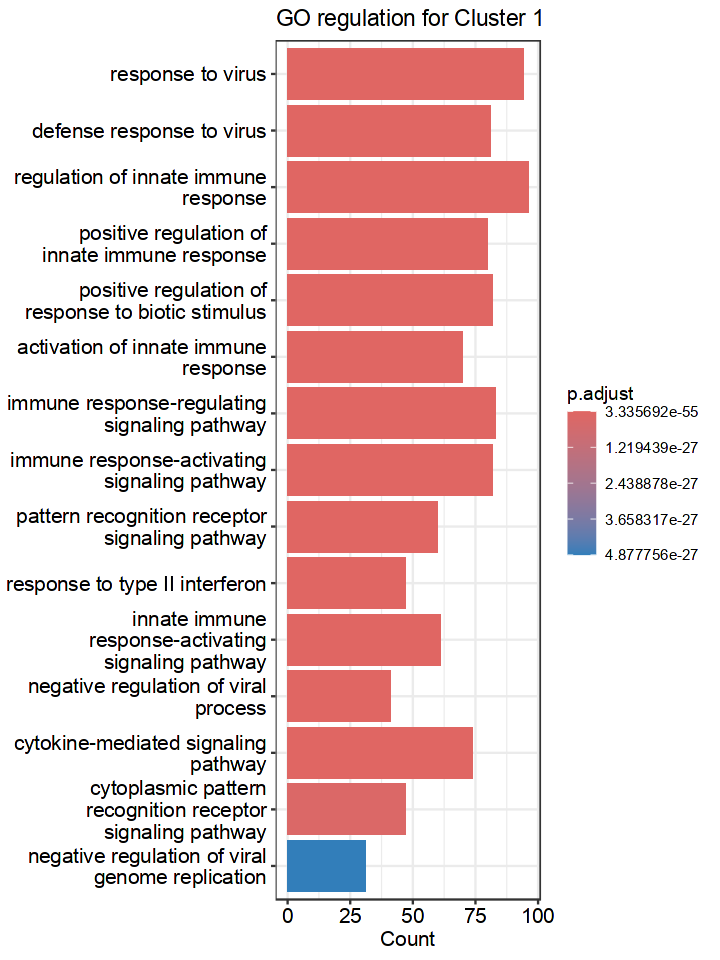

In [34]:
options(repr.plot.width = 6, repr.plot.height = 8)
barplot(Cluster1.ego, showCategory=15, title="GO regulation for Cluster 1")

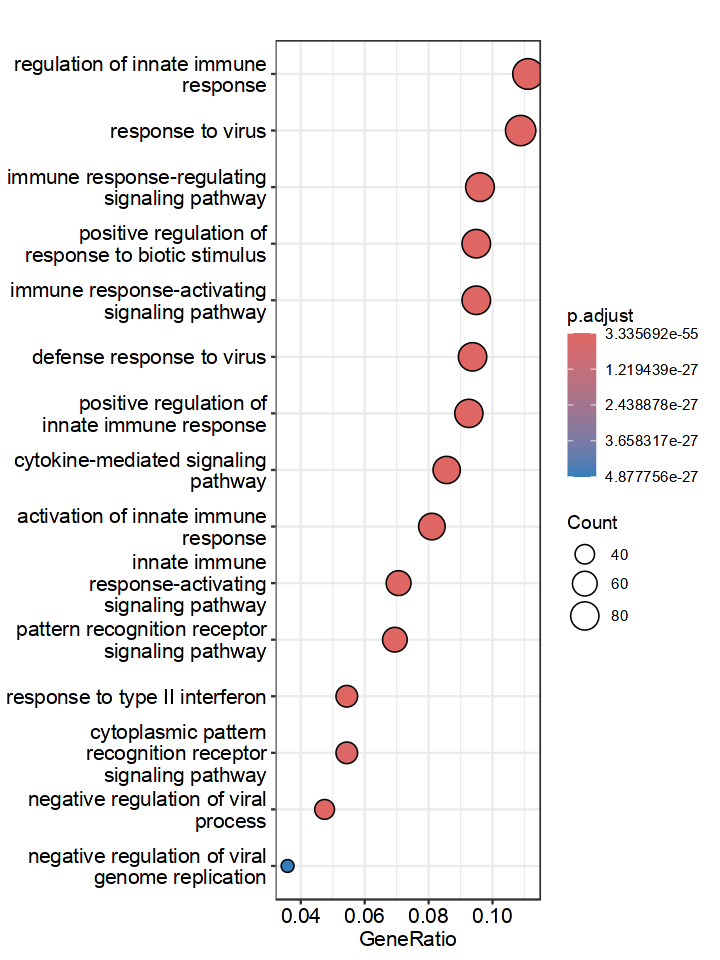

In [35]:
# GO Analysis for Cluster 0
options(repr.plot.width = 6, repr.plot.height = 8)
p1 <- dotplot(Cluster1.ego, showCategory=15)
p1

In [36]:
Cluster1.ego.simplify <- simplify(Cluster1.ego)

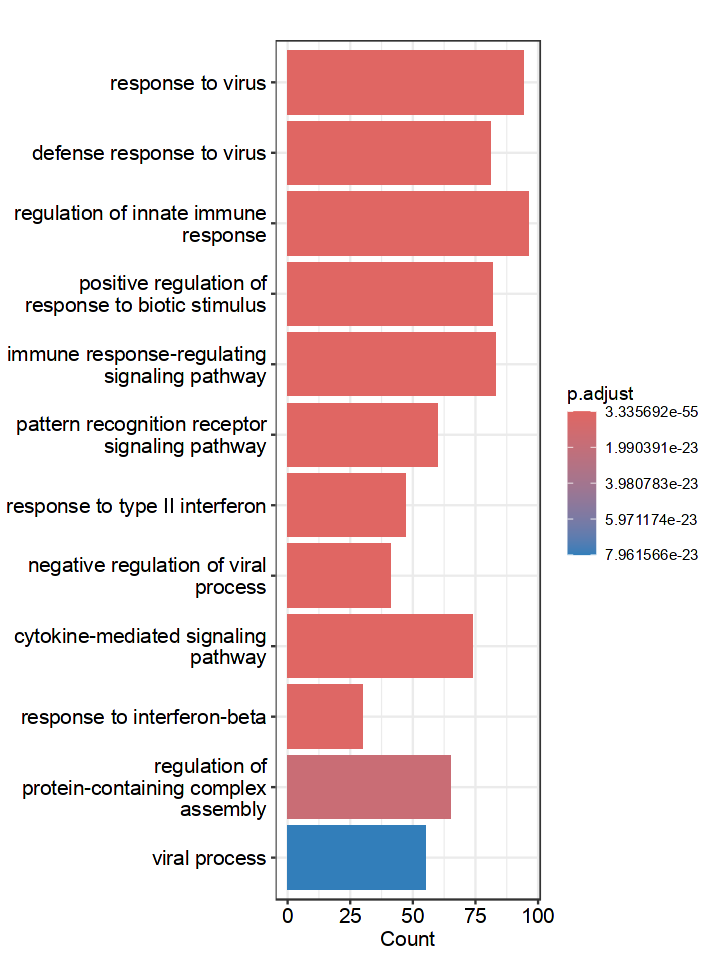

In [37]:
barplot(Cluster1.ego.simplify, drop=TRUE, showCategory=12)

## 1-2. Immune related GO analysis

In [38]:
Cluster1_filter.ego <- enrichGO(gene = Cluster1_filter.gene_ids$ENTREZID, 
                        OrgDb = org.Mm.eg.db, 
                        ont = "BP", # biological process
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

In [39]:
Cluster1_filter.ego@result <- Cluster1_filter.ego@result[Cluster1_filter.ego@result$ID %in% descendant_terms,]

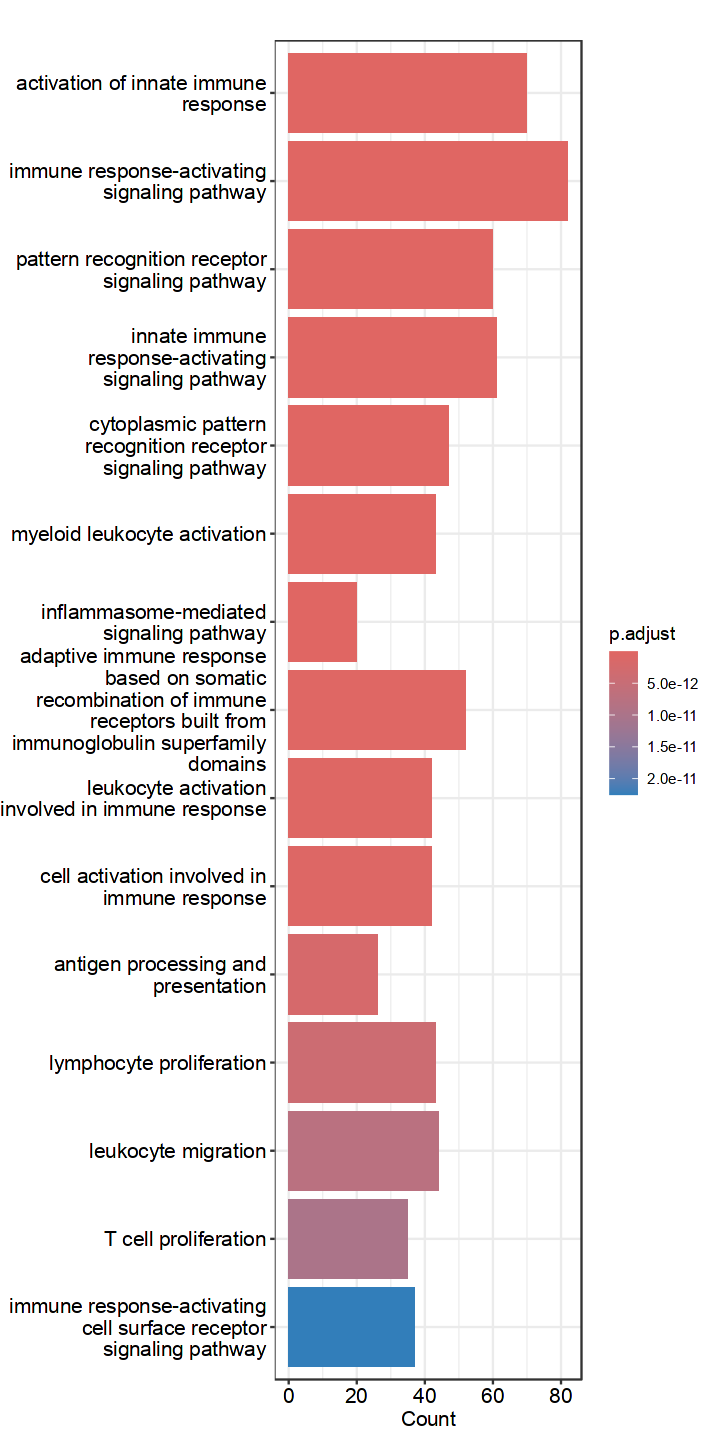

In [40]:
# immune system process
options(repr.plot.width = 6, repr.plot.height = 12)
barplot(Cluster1_filter.ego, showCategory=15)

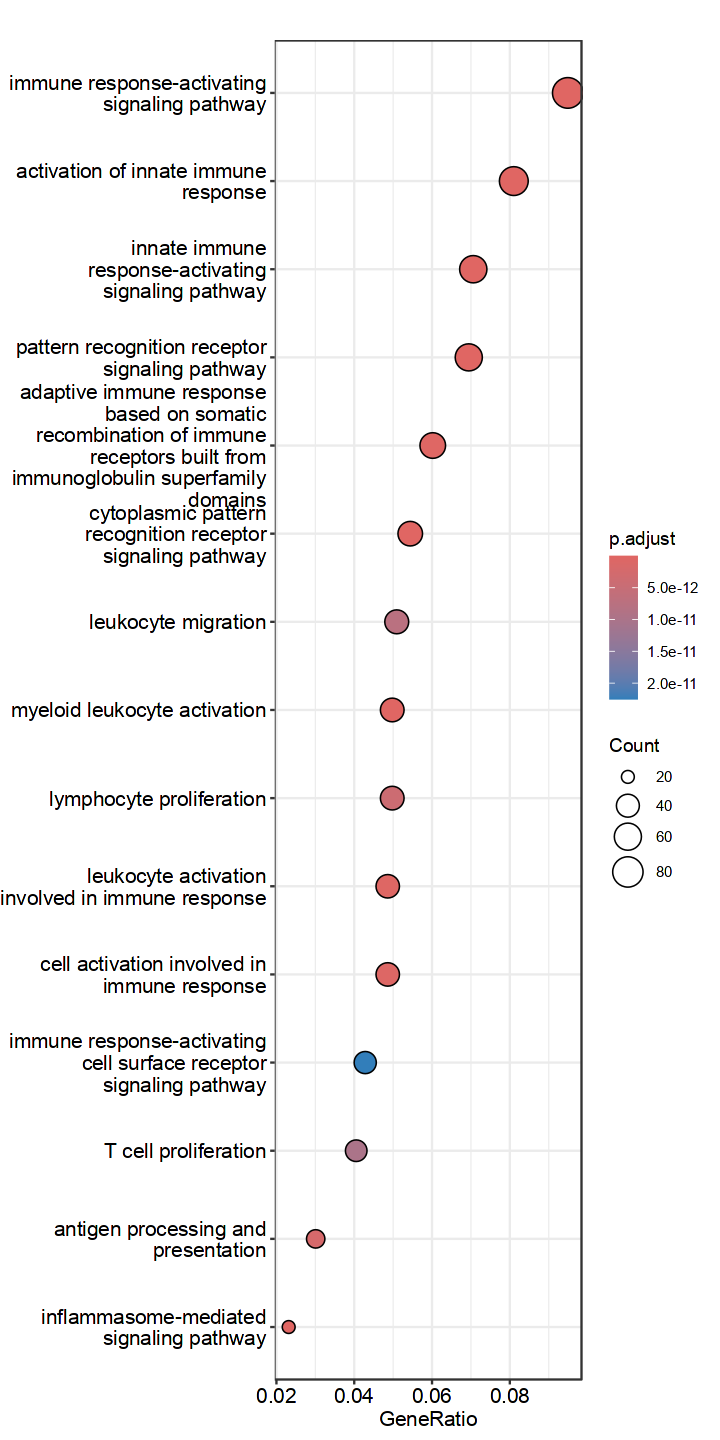

In [41]:
# GO immune related response Analysis for Cluster 1
options(repr.plot.width = 6, repr.plot.height = 12)
dotplot(Cluster1_filter.ego, showCategory=15)

## 1-3. Depletion alaysis

In [42]:
Cluster1_convert.ego <- enrichGO(gene = Cluster1_convert.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

In [43]:
Cluster1_convert.ego@result <- Cluster1_convert.ego@result[Cluster1_convert.ego@result$ID %in% descendant_terms,]

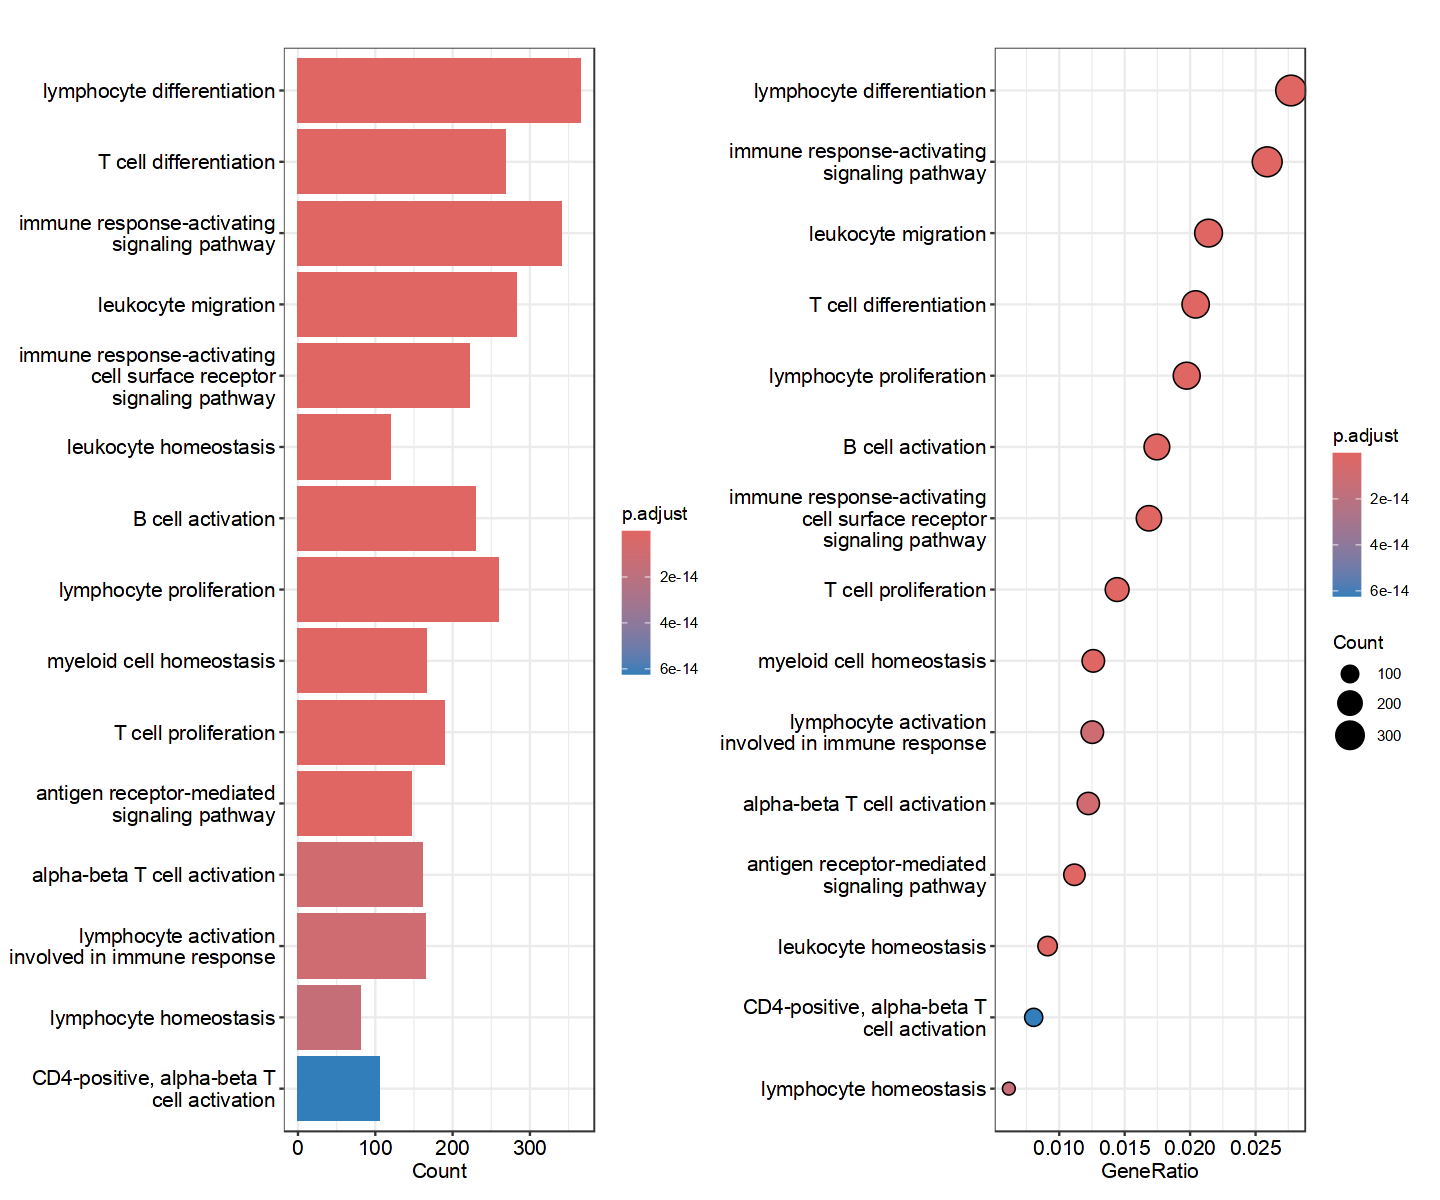

In [44]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster1_convert.ego, showCategory=15)
p1<-dotplot(Cluster1_convert.ego, showCategory=15)
options(repr.plot.width = 12, repr.plot.height = 10)
p0+p1

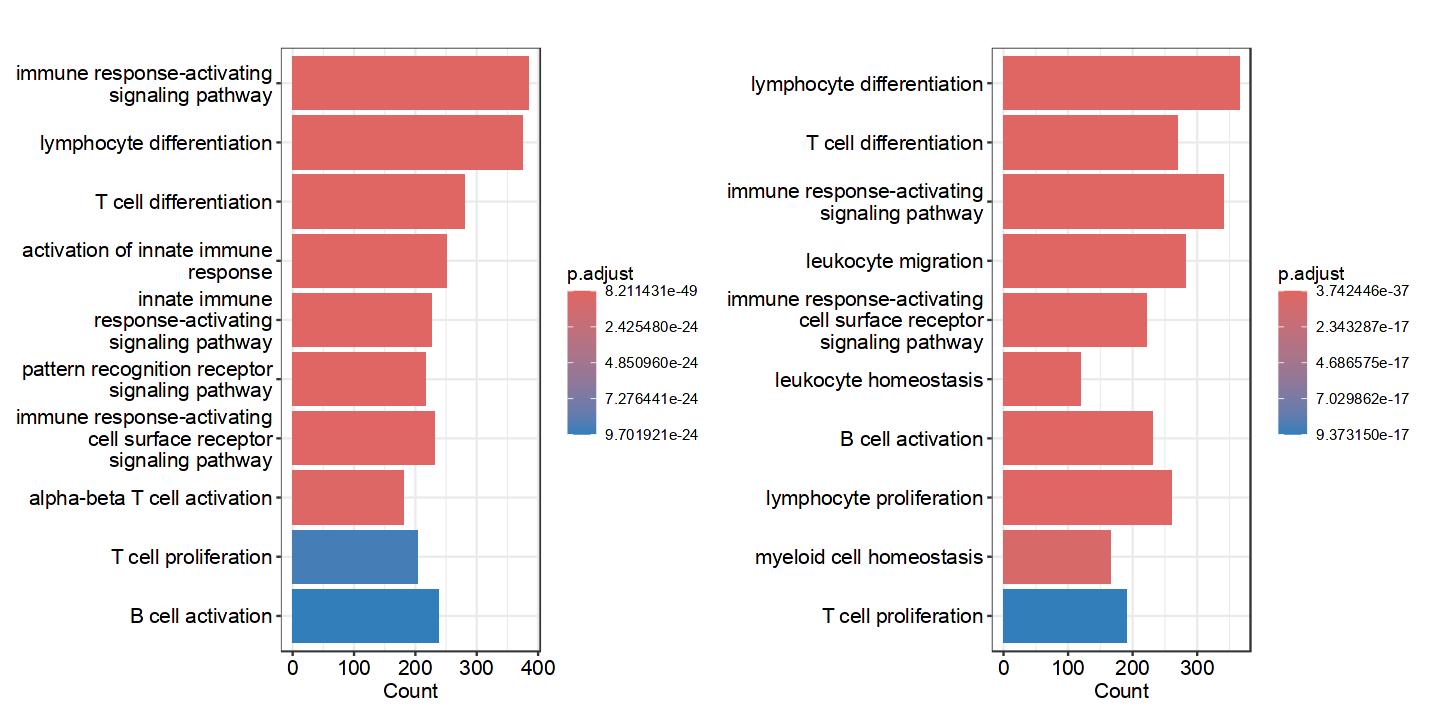

In [45]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0_convert.ego, showCategory=10)
p1<-barplot(Cluster1_convert.ego, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

# Cluser 0 vs 1 Summary

In [46]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0.ego, showCategory=10)
p1<-barplot(Cluster1.ego, showCategory=10)

ggsave(file = file.path(out_dir, "01_cluster0_barplot.jpeg"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "01_cluster1_barplot.jpeg"), plot = p1, width = 6, height = 6, dpi = 300)

ggsave(file = file.path(out_dir, "01_cluster0_barplot.pdf"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "01_cluster1_barplot.pdf"), plot = p1, width = 6, height = 6, dpi = 300)

In [47]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0_convert.ego, showCategory=10)
p1<-barplot(Cluster1_convert.ego, showCategory=10)

ggsave(file = file.path(out_dir, "02_cluster0_dep_barplot.jpeg"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "02_cluster1_dep_barplot.jpeg"), plot = p1, width = 6, height = 6, dpi = 300)

ggsave(file = file.path(out_dir, "02_cluster0_dep_barplot.pdf"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "02_cluster1_dep_barplot.pdf"), plot = p1, width = 6, height = 6, dpi = 300)

## Simplify

In [48]:
Cluster1_convert.ego.simplify <- simplify(Cluster1_convert.ego)

In [49]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0.ego.simplify, showCategory=10, title="Enriched in Cluster 0")
p1<-barplot(Cluster1.ego.simplify, showCategory=10, title="Enriched in Cluster 1")

ggsave(file = file.path(out_dir, "01_cluster0_barplot_simplify.jpeg"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "01_cluster1_barplot_simplify.jpeg"), plot = p1, width = 6, height = 6, dpi = 300)

ggsave(file = file.path(out_dir, "01_cluster0_barplot_simplify.pdf"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "01_cluster1_barplot_simplify.pdf"), plot = p1, width = 6, height = 6, dpi = 300)

In [50]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0_convert.ego.simplify, showCategory=10, title="Cluster 0")
p1<-barplot(Cluster1_convert.ego.simplify, showCategory=10, title="Cluster 1")

ggsave(file = file.path(out_dir, "02_cluster0_dep_barplot_simplify.jpeg"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "02_cluster1_dep_barplot_simplify.jpeg"), plot = p1, width = 6, height = 6, dpi = 300)

ggsave(file = file.path(out_dir, "02_cluster0_dep_barplot_simplify.pdf"), plot = p0, width = 6, height = 6, dpi = 300)
ggsave(file = file.path(out_dir, "02_cluster1_dep_barplot_simplify.pdf"), plot = p1, width = 6, height = 6, dpi = 300)

In [51]:
head(as.data.frame(Cluster0_convert.ego.simplify))

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002757,GO:0002757,immune response-activating signaling pathway,384/13249,486/28905,0.7901235,1.723792,14.80327,1.398231e-51,8.211431e-49,2.882096e-49,Zap70/Slc39a10/Cd28/Ctla4/Bcl2/Fcmr/Mapkapk2/Rab29/Lax1/Ptprc/Nek7/Dennd1b/Ptgs2os/Rc3h1/Cd247/Fcer1g/Aim2/Ifi206/Ifi214/Ifi213/Ifi209/Ifi208/Ifi207/Ifi204/Mndal/Ifi211/Ifi203/Ifi205/Tlr5/Lyplal1/Traf3ip3/Gata3/Phpt1/Rapgef1/Zdhhc12/Abl1/Dab2ip/Rc3h2/Ppp6c/Nmi/Cacnb4/Ifih1/Zdhhc5/Ptprj/Nr1h3/Traf6/Tyro3/Usp50/Mavs/Prnp/Rbck1/Zcchc3/Itch/Sla2/Src/Lbp/Plcg1/Ada/Nfatc2/Lime1/Tlr2/S100a14/S100a8/S100a9/Cd160/Nras/Ptpn22/Rap1a/Vav3/Alpk1/Tifa/Nfkb1/Gbp5/Gbp2/Bcl10/Lyn/Ripk2/Map3k7/Stoml2/Shb/Nr4a3/Slc46a2/Trim32/Tlr4/Pde4b/Skint3/Eif2b3/Zc3h12a/Tlr12/Lck/Khdrbs1/Pum1/Laptm5/Smpdl3b/Themis2/Gpatch3/Zdhhc18/Zfp683/Cptp/Eif2b4/Fosl2/Tnip2/Cd38/Tlr1/Tlr6/Txk/Usp46/Stap1/Ankrd17/Gfi1/Cmklr1/Oasl1/Sppl3/Oas3/Oas1c/Oas1g/Oas1a/Rnf34/Eif2b1/Slc15a4/Lrch4/Pvrig/Card11/Usp12/Hmgb1/Cav1/Zc3hav1/Braf/Tax1bp1/Nod1/Tnip3/Cd8a/Foxp1/Irak2/Wnk1/Phb2/Ptpn6/Clec2i/Klre1/Klrd1/Klrk1/Klrc3/Klrc2/Klrc1/Klri1/Klri2/Kcnj8/Nop53/C5ar2/Prkd2/Mark4/Nectin2/Cd79a/Sirt2/Tyrobp/Nfkbid/Ffar2/Cd22/Lsm14a/Irf3/Tmem126a/Rps3/Clpb/Trim30a/Trim3/Prkcb/Lat/Cd19/Pycard/Plekha1/Hras/Irf7/Cd81/Rnf170/Mfhas1/Tlr3/Irf2/Ddx60/Fcho1/Otud4/Nod2/Cyld/Cmtm3/Carmil2/Znrf1/Bcar1/Plcg2/Cyba/Casp1/Casp4/Ecsit/Tirap/Hspa8/Thy1/Nlrx1/Cd3e/Csk/Cd276/Cgas/Bcl2a1d/Plscr1/Plscr2/Tlr9/Mapkapk3/Ltf/Fbxl2/Myd88/Esr1/Tnfaip3/Themis/Fyn/Lilrb4a/Icosl/Stk11/Cactin/Hcfc2/Ube2n/Pawr/Ifng/Irak3/Tbk1/Usp15/Tespa1/Myo1g/Peli1/Rtn4/Lcp2/Itk/Havcr2/Irgm1/Btnl9/Ppp2ca/Irf1/Tnip1/Igtp/Irgm2/Trim11/Aurkb/Gps2/Scimp/Dhx33/Nlrp1a/Nlrp1b/Ywhae/Sarm1/Rnf135/Trim25/Skap1/Nr1d1/Ccr7/Dhx58/Naglu/Becn1/Ifi35/Dusp3/Cd79b/Cd300a/Cd300ld3/Cd300lf/Grb2/Nploc4/Pum2/Rsad2/Gpr33/Arf6/Prkch/Psen1/Eif2b2/Traf3/Akt1/Ighm/Gpld1/Dusp22/Irf4/Syk/Tifab/Ubqln1/Mef2c/Ap3b1/F2rl1/Pik3r1/Erbin/Pde4d/Appl1/Mapk8/Tlr11/Rnf31/Blk/Lacc1/Elf1/Acod1/Otulin/Lrrc14/Nfam1/Gramd4/Cacnb3/Pcbp2/Tarbp2/Nckap1l/Mefv/Nlrc3/Prkdc/Mapk1/Crkl/Ufd1/Klhl6/Eif2b5/Cd86/Slc15a2/Gcsam/Trat1/Cd47/Cblb/Ezr/Fpr1/Fpr2/Pdpk1/Ubash3a/Pram1/H2-K1/Btnl2/Bag6/Tnf/Nfkbil1/H2-D1/H2-Q2/H2-Q4/H2-Q6/H2-Q10/Flot1/Atat1/Cd2ap/Tnfrsf21/Treml4/Rftn1/Plcl2/Ticam1/Ptprs/C3/Gpr108/Pja2/Eif2ak2/Sos1/Prkce/Colec12/Riok3/Rnf125/Slc39a6/Ticam2/Csnk1a1/Malt1/Ptpn2/Epg5/Cd226/Unc93b1/Banf1/Fosl1/Rela/Tkfc/Slc15a3/Ms4a1/Cd274/Blnk/Pik3ap1/Chuk/Rab11fip2/Foxp3/Usp9x/Ddx3x/Lamp2/Sh2d1a/Irak1/Ikbkg/Brcc3/Tlr13/Tspan6/Btk/Rps6ka3/Bmx/Tlr8/Tlr7/Lgr4/Ermap/Peli3,384
GO:0030098,GO:0030098,lymphocyte differentiation,375/13249,490/28905,0.7653061,1.669649,13.75312,2.219844e-44,4.625868e-42,1.623614e-42,Zap70/Il1rl2/Il18r1/Stat4/Fzd7/Cd28/Ctla4/Fzd5/Nhej1/Dock10/Inpp5d/Bcl2/Il10/Sox13/Ptprc/Mr1/Abl2/Rc3h1/Tnfsf4/Tnfsf18/Pbx1/Fcer1g/Ly9/Slamf1/Slamf6/Slamf8/Itpkb/Dusp10/Hlx/Cd46/Cr2/Dclre1c/Gata3/Il2ra/Il15ra/Bmi1/Nrarp/Fut7/Tsc1/Abl1/Rc3h2/Dpp4/Atf2/Ptprj/Spi1/Ambra1/Mdk/Cd44/Rasgrp1/Dll4/Tyro3/B2m/Mertk/Zc3h8/Il1b/Sox12/Ada/Prex1/Adrm1/Il7/Tpd52/Actl6a/Il2/Il21/Il12a/Tmem131l/Cd1d1/Sema4a/Gon4l/Zbtb7b/Il6ra/Rorc/Gpr89/Notch2/Ptpn22/Lef1/Tox/Chd7/Cdh17/Ripk2/Wwp1/Il11ra1/Shb/Slc46a2/Tnfsf8/Rps6/Ifnb1/Cdkn2a/Zc3h12a/Lck/Laptm5/Arid1a/Zfp683/Runx3/Wnt4/Mtor/Tnfrsf9/Rpl22/Prkcz/Fgl2/Slc4a2/Smarcd3/Il6/Fosl2/Rhoh/Txk/Kit/Dtx1/Sh2b3/Fzd9/Hspb1/Lfng/Card11/Actb/Flt3/Hmgb1/Phf14/Braf/Ezh2/Gimap1/Gimap5/Gimap3/Igkc/Cd8a/Loxl3/Foxp1/Fancd2/Ptpn6/Cd4/Lag3/Cd27/Cracr2a/Itfg2/Pglyrp1/Relb/Clptm1/Bcl3/Cd79a/Pou2f2/Tgfb1/Nfkbid/Cebpg/Spib/Il4i1/Flt3l/Kdelr1/Klhl25/Blm/Il4ra/Cd19/Il27/Spn/Armc5/Ascl2/Fadd/Clec4g/Lig4/Tnfsf13b/Pcid2/Gas6/Sh3rf1/Jak3/Il15/Lyl1/Prdx2/Brd7/Cyld/Adgrg3/Pdp2/Cbfb/Carmil2/Nfatc3/Plcg2/Irf8/Fanca/Irf2bp2/Smarca4/Crtam/Kmt2a/Cd3g/Cd3d/Cd3e/Mpzl2/Zbtb16/Il18/Pou2af1/Atm/Zfp609/Rora/Bcl2a1d/Tlr9/Dcaf1/Tusc2/Rhoa/Cmtm7/Tgfbr2/Eomes/Ctnnb1/Ccr9/Ccr2/Tnfaip3/M

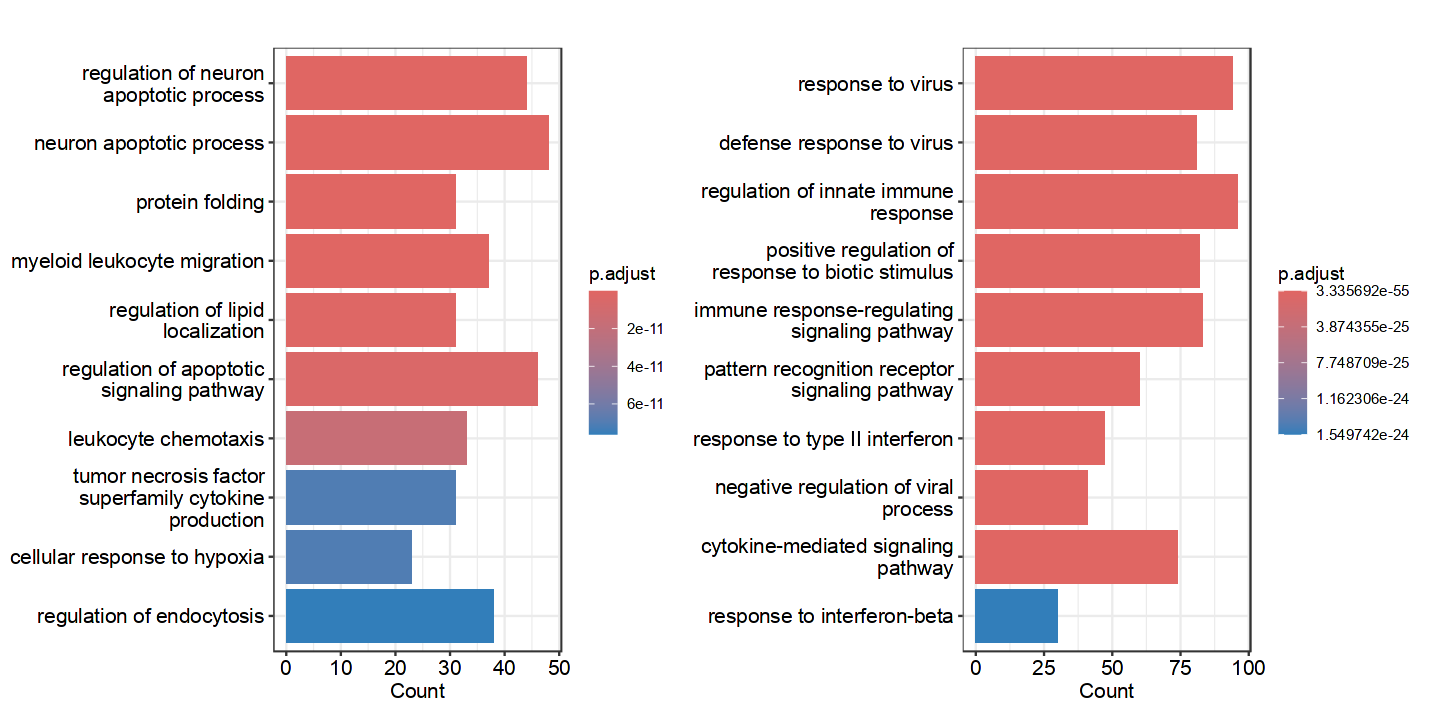

In [52]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0.ego.simplify, showCategory=10)
p1<-barplot(Cluster1.ego.simplify, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

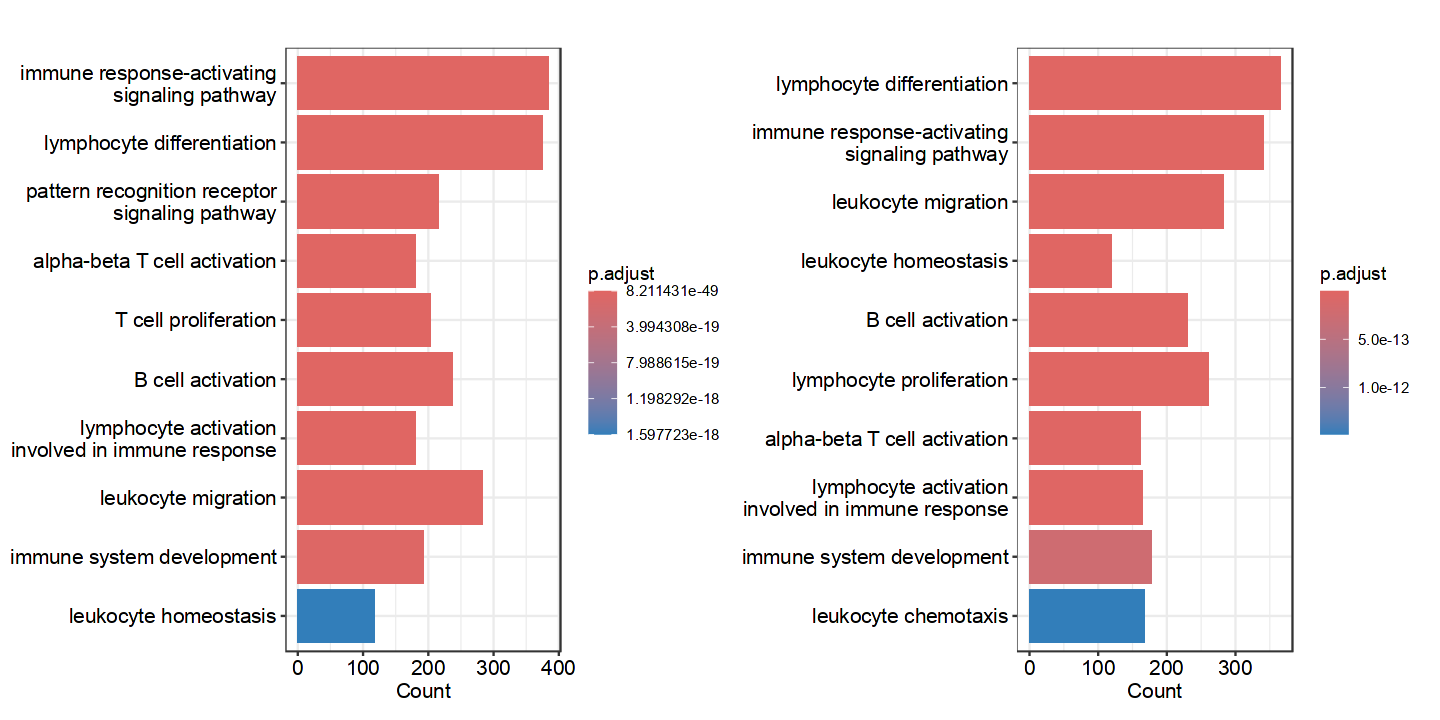

In [53]:
# GO Depletion Analysis for Cluster 0
p0<-barplot(Cluster0_convert.ego.simplify, showCategory=10)
p1<-barplot(Cluster1_convert.ego.simplify, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

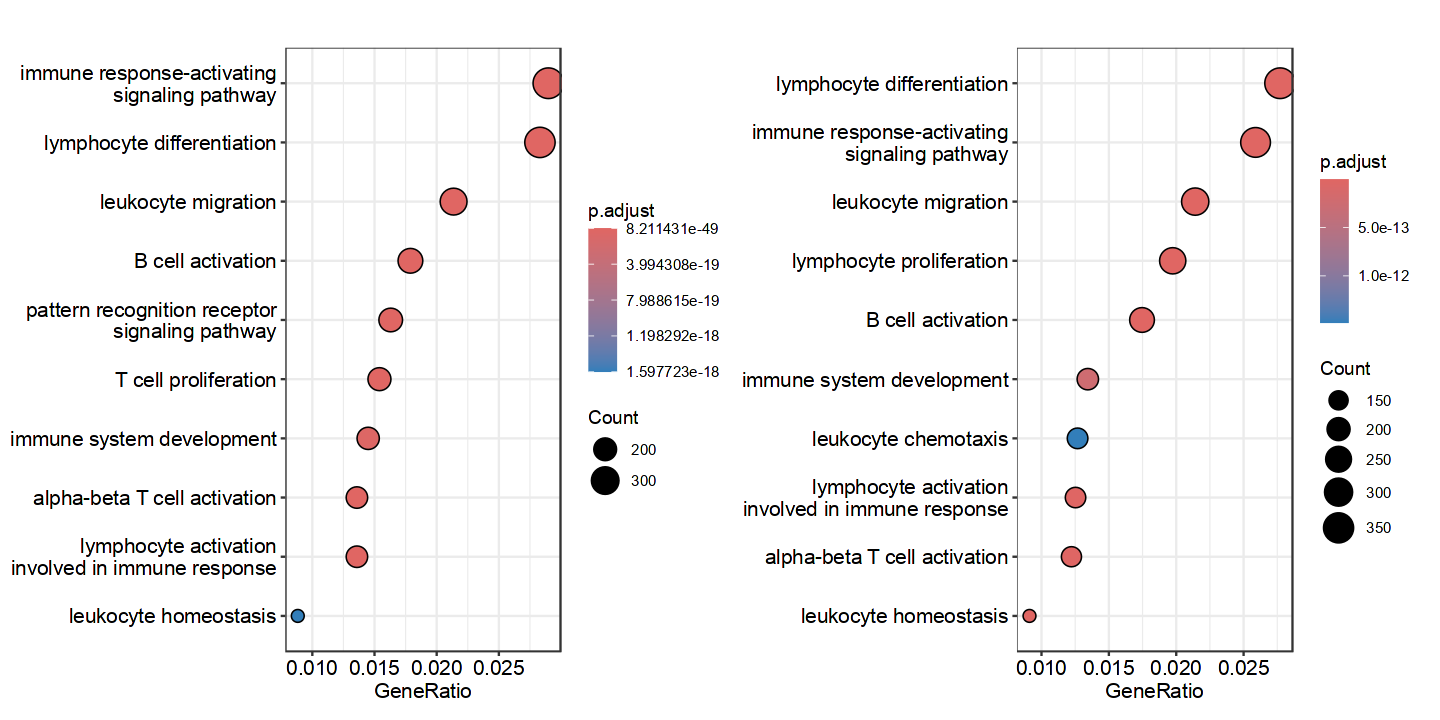

In [54]:
# GO Depletion Analysis for Cluster 0
p0<-dotplot(Cluster0_convert.ego.simplify, showCategory=10)
p1<-dotplot(Cluster1_convert.ego.simplify, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

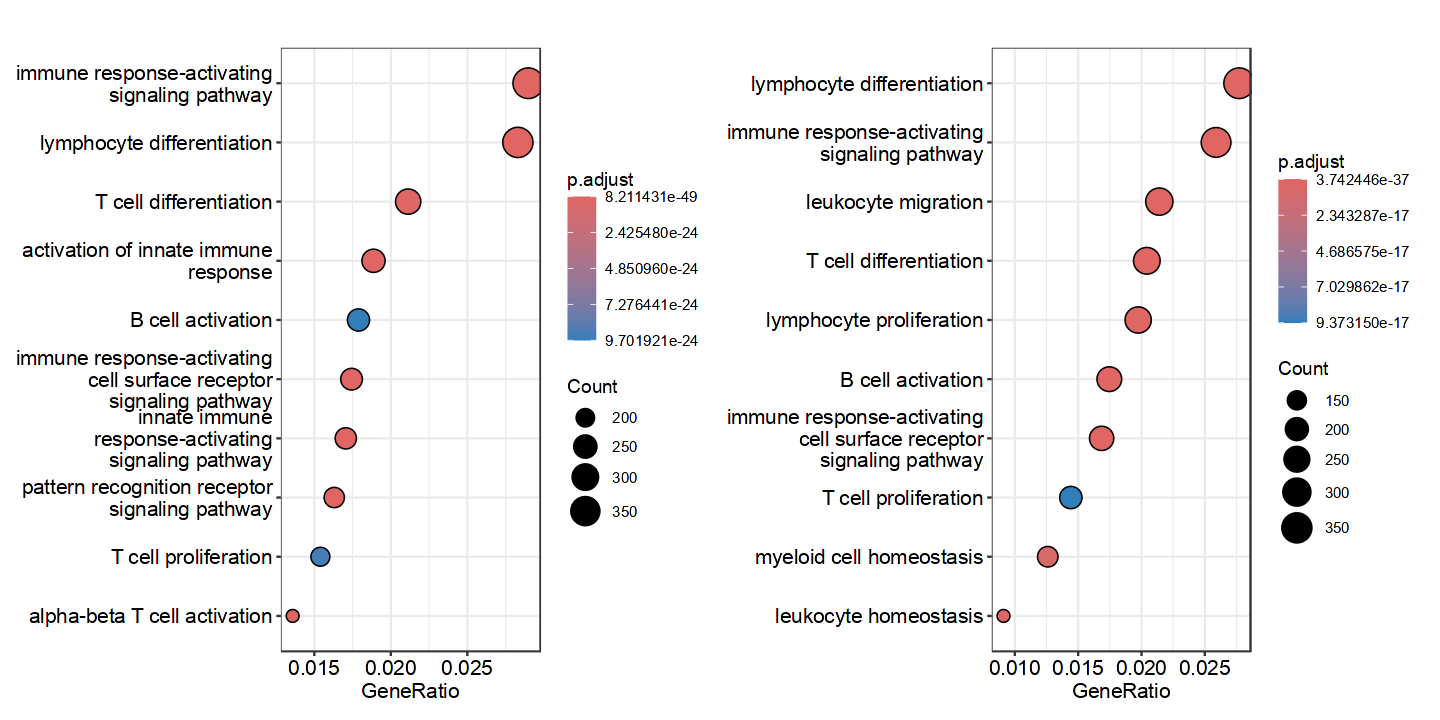

In [55]:
# GO Depletion Analysis for Cluster 0
p0<-dotplot(Cluster0_convert.ego, showCategory=10)
p1<-dotplot(Cluster1_convert.ego, showCategory=10)
options(repr.plot.width = 12, repr.plot.height = 6)
p0+p1

# Cluster 2

## 2-1. GO analysis

In [56]:
Cluster2.ego <- enrichGO(gene = Cluster2.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

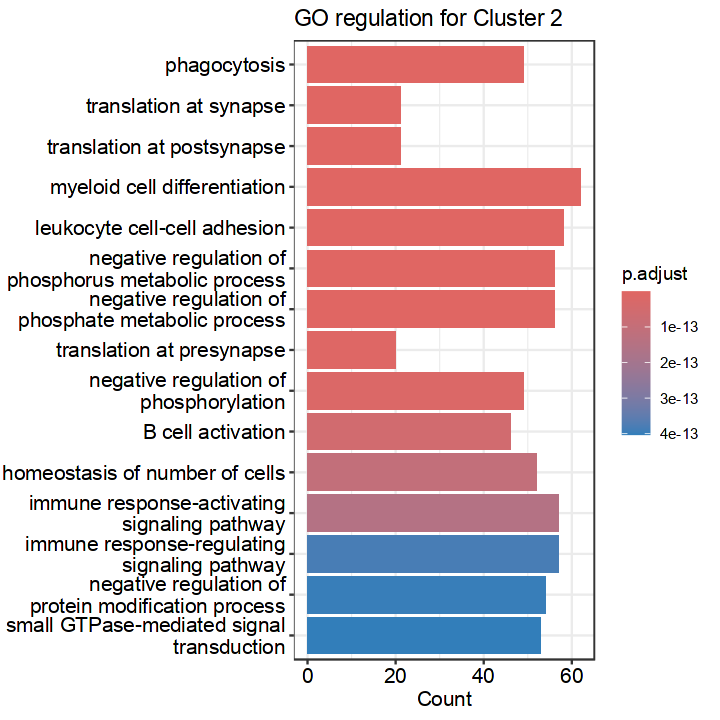

In [57]:
options(repr.plot.width = 6, repr.plot.height = 6)
barplot(Cluster2.ego, showCategory=15, 
        title="GO regulation for Cluster 2")

## 2-2. Depletion

In [58]:
Cluster2_filter.ego <- enrichGO(gene = Cluster2_filter.gene_ids$ENTREZID, 
                        OrgDb = org.Mm.eg.db, 
                        ont = "BP", # biological process
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

In [59]:
#Cluster2_filter.ego@result <- Cluster2_filter.ego@result[Cluster2_filter.ego@result$ID %in% descendant_terms,]

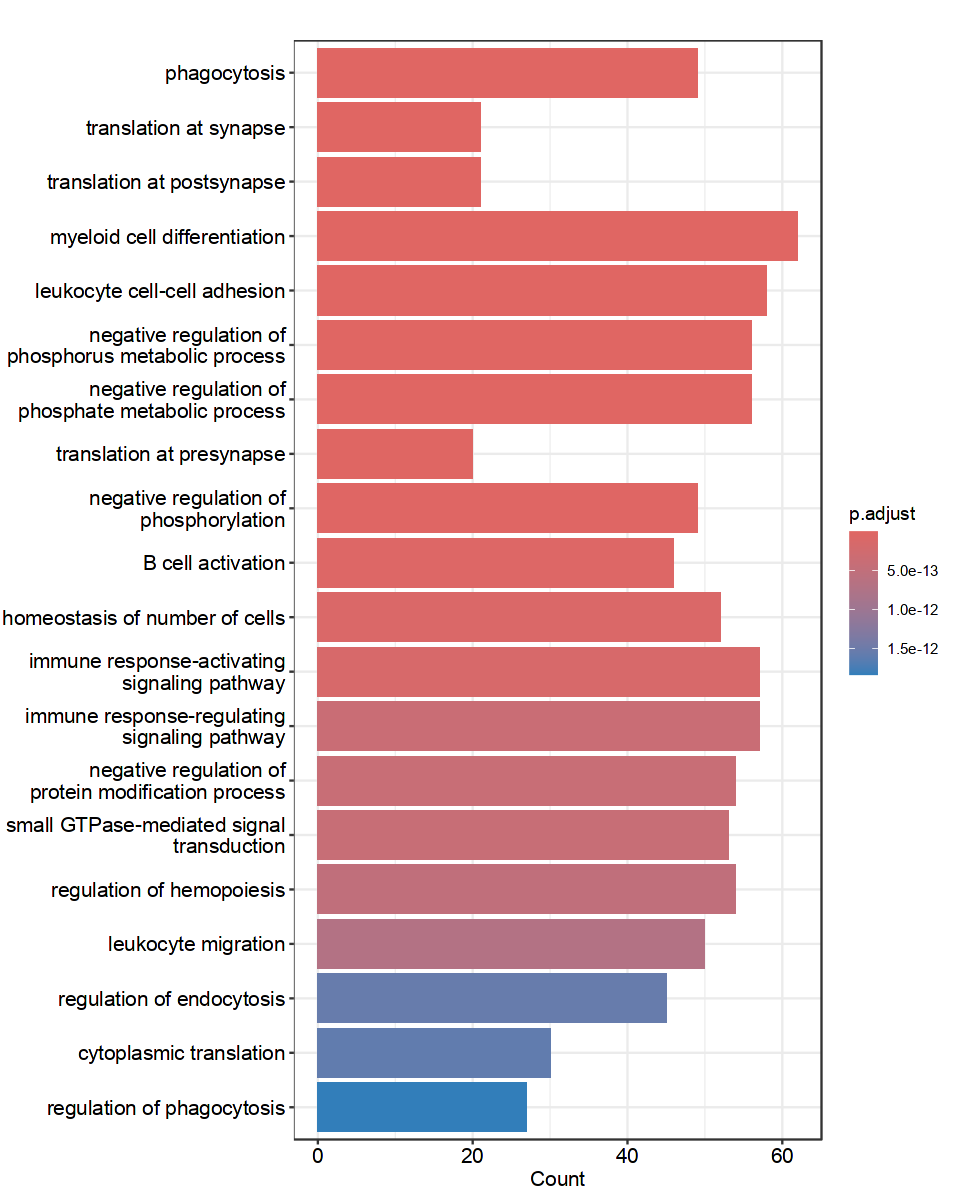

In [60]:
# "GO regulation for Cluster 2"
options(repr.plot.width = 8, repr.plot.height = 10)
barplot(Cluster2_filter.ego, showCategory=20)

# Cluster 3

In [61]:
Cluster3.ego <- enrichGO(gene = Cluster3.gene_ids$ENTREZID, 
                OrgDb = org.Mm.eg.db, 
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)

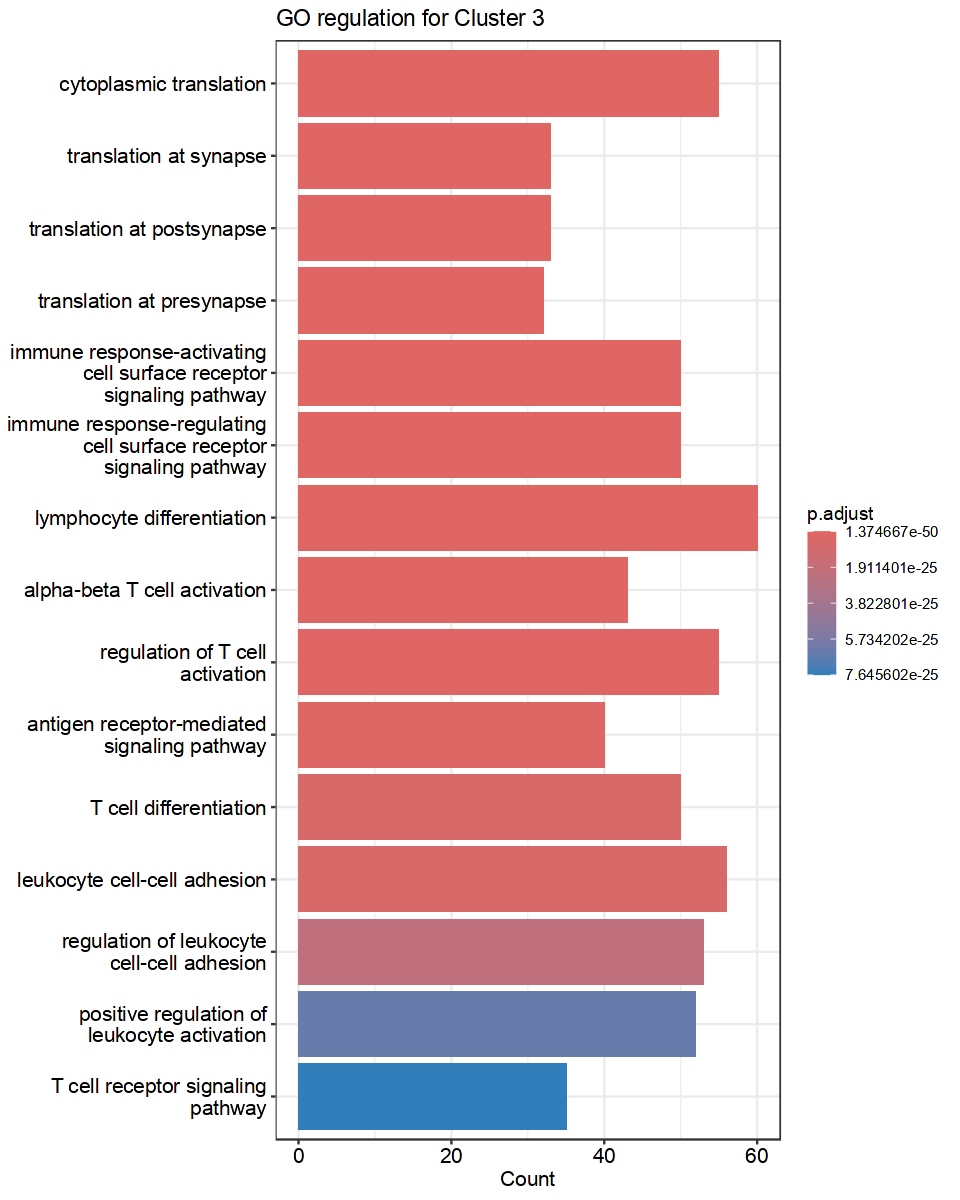

In [62]:
options(repr.plot.width = 8, repr.plot.height = 10)
barplot(Cluster3.ego, showCategory=15, 
        title="GO regulation for Cluster 3")

In [63]:
format(Sys.time(), tz = "Asia/Tokyo", usetz = TRUE)

[1] "2025-08-27 15:59:26 JST"